## IMPLEMENTATION


### I. Installing libraries and dependencies

In [4]:
# Importing framework for Natural Language Processing (NLP) model development
import tensorflow as tf

In [ ]:
# Making sure a Graphics Processeing Unit (GPU) is available to be able to handle the computational requirements of a
# large-sized machine learning model
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print('Num GPUs Available: ', num_gpus_available)  # Note that the model will require the use of GPU
assert num_gpus_available > 0

In [87]:
# Installing transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
# Installing version of pandas_ta and numpy v1.19.5 that are compatible with colab 
# and don't create conflicts when it comes to dependencies
! pip install pandas_ta==0.2.45b 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 5.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [89]:
# Importing data analysis tools and modules for NLP tasks
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np

In [90]:
# Importing NLTK to be able to perform futher NLP tasks
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### II. Importing data set, light exploratory data analysis, and light pre-processing

The dataset that I am using is the **amazon personal care appliances reviews** which is a subset of the large Amazon Product review. The dataset is already stored in the **TensorFlow database** and can be loaded directly using the ‘tfds‘ API from Tensorflow. 

The dataset consists of reviews of **Amazon Personal_Care_Appliances_v1_00 products in US marketplace**.

In [91]:
import tensorflow_datasets as tfds
ds = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

<_OptionsDataset element_spec={'data': {'customer_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'helpful_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'marketplace': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_category': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_parent': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_body': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_date': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_headline': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'star_rating': TensorSpec(shape=(), dtype=tf.int32, name=None), 'total_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'verified_purchase': TensorSpec(shape=(), dtype=tf.int64, name=None), 'vine': TensorSpec(shape=(), dtype=

In [92]:
# Converting dataset into a pandas data frame using ‘tfds.as_dataframe‘ API.
df = tfds.as_dataframe(ds)

In [93]:
# Getting a glimpse of the data frame
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'13986323',0,b'US',b'Personal_Care_Appliances',b'B00847JQZ6',b'997683625',"b'SE - Reading Glass - Spring Loaded Hinges, 4...","b""These glasses are an excellent value. The f...",b'2015-01-04',b'These glasses are an excellent value. The fi...,b'R3VEUFVA9QJY55',4,0,0,1
1,b'50574716',3,b'US',b'Personal_Care_Appliances',b'B00N5HD340',b'955577225',b'Straight Razor',"b""Always wanted to try straight razor shaving ...",b'2015-08-05',b'A fantastic way to cheaply try straight razo...,b'R2DTQV5SMJ0CK7',5,3,0,1
2,b'50593972',0,b'US',b'Personal_Care_Appliances',b'B0077L1X24',b'120764066',b'Philips Sonicare Flexcare & Healthy White Pl...,b'I usually either throw my toothbrush in a pl...,b'2012-11-17',b'Great for travel',b'R3OJ06NK99WLNJ',4,0,0,1
3,b'18935813',0,b'US',b'Personal_Care_Appliances',b'B001CHCQ9I',b'830133534',b'Massage Table Sheet Set - Poly/cotton',b'Top quality.',b'2014-12-22',b'Five Stars',b'R3B4JKHR1KTI7J',5,0,0,1
4,b'48412788',1,b'US',b'Personal_Care_Appliances',b'B0016BJS2S',b'925685259',"b'TRIMEDICA, AlkaMax pH Plus Liquid - 1 oz'","b'Today I received 1 Fl. Oz, Natures Balance ...",b'2014-06-11',b'*Product sent not as shown',b'R3H50GB2FS0QPC',3,1,0,1


In [94]:
# Getting the number of rows and columns
df.shape

(85981, 15)

In [95]:
# Getting useful information about the data frame
# It is critical information to note that the column containing the labels (i.e. 'star_rating') is integer in type
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   data/customer_id        85981 non-null  object
 1   data/helpful_votes      85981 non-null  int32 
 2   data/marketplace        85981 non-null  object
 3   data/product_category   85981 non-null  object
 4   data/product_id         85981 non-null  object
 5   data/product_parent     85981 non-null  object
 6   data/product_title      85981 non-null  object
 7   data/review_body        85981 non-null  object
 8   data/review_date        85981 non-null  object
 9   data/review_headline    85981 non-null  object
 10  data/review_id          85981 non-null  object
 11  data/star_rating        85981 non-null  int32 
 12  data/total_votes        85981 non-null  int32 
 13  data/verified_purchase  85981 non-null  int64 
 14  data/vine               8598

In [96]:
# Getting statistical information about the data frame
# Based on the count, mean, and max values, the data frame contains data that is normalised more or less
df.describe()

,data/helpful_votes,data/star_rating,data/total_votes,data/verified_purchase,data/vine
count,85981.000000,85981.000000,85981.000000,85981.000000,85981.000000
mean,3.349484,3.977402,4.058990,0.263651,0.999628
std,19.483167,1.433130,20.825996,0.440615,0.019288
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,1.000000
50%,0.000000,5.000000,1.000000,0.000000,1.000000
75%,2.000000,5.000000,3.000000,1.000000,1.000000
max,2785.000000,5.000000,2876.000000,1.000000,1.000000


In [97]:
# Finding out the total number of instances of both positive and negative reviews
# From a range of 0-5, I will consider a positive rating as a value between 3-5, while 
# anything less than 3 is a negative rating
df['data/star_rating'].value_counts()

5    48897
4    13657
1    11036
3     7050
2     5341
Name: data/star_rating, dtype: int64

**BINARY CLASSIFICATION & IMPUTING 'SENTIMENT' AND 'WORD_COUNTS' FEATURES**

The **rating provided by the customer is on a scale of 1-5**( 5 being the highest). As I am going to implement a *binary classification model*, I shall be converting these ratings into 2 categories, i.e 1 and 0. **Ratings above and equal to 3 will be labeled as Positive(1)** and **below 3 will be negative(0)**. The following code will help us implement these steps.

In [98]:
df['Sentiment'] = df['data/star_rating'].apply(lambda score: 'positive' if score >= 3 else 'negative')
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})

In [99]:
df['short_review'] =df['data/review_body'].str.decode("utf-8")

In [100]:
df = df[['short_review', 'Sentiment']]

In [101]:
# Getting a glimpse of the new data frame
df.head()

,short_review,Sentiment
0,These glasses are an excellent value. The fit...,1
1,Always wanted to try straight razor shaving (a...,1
2,I usually either throw my toothbrush in a plas...,1
3,Top quality.,1
4,"Today I received 1 Fl. Oz, Natures Balance Al...",1


In [102]:
# Adding another feature 'word_counts' to the data frame
df['word_counts'] = df['short_review'].apply(lambda x: len(str(x.split())))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
# Again taking a glance at the data frame
df.head()

,short_review,Sentiment,word_counts
0,These glasses are an excellent value. The fit...,1,465
1,Always wanted to try straight razor shaving (a...,1,1169
2,I usually either throw my toothbrush in a plas...,1,347
3,Top quality.,1,19
4,"Today I received 1 Fl. Oz, Natures Balance Al...",1,1211


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85981 entries, 0 to 85980
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   short_review  85981 non-null  object
 1   Sentiment     85981 non-null  int64 
 2   word_counts   85981 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


**PLOTTING AVERAGE NUMBER OF WORDS IN POSITIVE (1) AND NEGATIVE (0) REVIEWS**

Text(0.5, 1.0, 'Avg. no. of words in short_review vs. Sentiment')

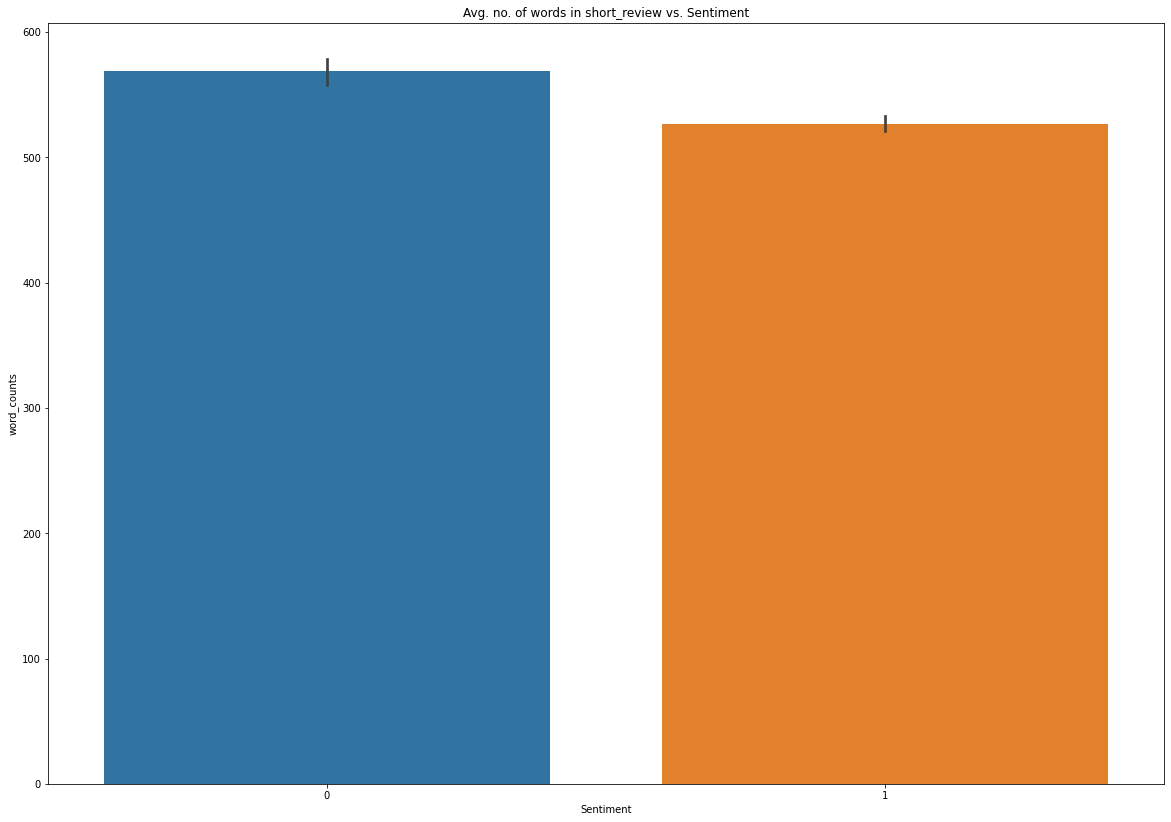

In [106]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,14))
sns.barplot(x='Sentiment', y='word_counts', data=df)
plt.title('Avg. no. of words in short_review vs. Sentiment')

**DISPLAYING NULL VALUES IF ANY IN ANY FEATURE**

In [107]:
print(df.isna().sum()) 

short_review    0
Sentiment       0
word_counts     0
dtype: int64


**NOTE**:
It appears that the **positive reviews on average contain lesser number of words relative to negative reviews**. 

**Anticipating Implementation of a Pre-trained BERT NLP model**

The dataset consists of several columns ranging from Product ID to reviews, heading, and star rating provided by the customer. For this project, I am extracting mainly the **reviews** (ie feature column) and the **corresponding rating provided by the customer** (i.e. label column). Hence, I am dropping the other features/columns in this data frame. 

Since our chosen pre-trained model, BERT, requires a lot of computational power and a huge corpus of training data for model development, I am only going to focus on the said two columns of the data frame. 

In [108]:
# Dropping last n rows using drop
n = 54975
df.drop(df.tail(n).index,
        inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [109]:
index = df.index
number_of_rows = len(index)
print(number_of_rows)

31006


In [110]:
# A glimpse of the tail-end of the data frame
df.tail()

,short_review,Sentiment,word_counts
31001,This is a magnificent little gadget!!! This m...,1,570
31002,This scale doesn't really work properly. it do...,1,307
31003,This review is about ear candles in general. ...,0,2017
31004,The shaver is outstanding!! Much better than I...,1,333
31005,As the reviews say... at this price point this...,1,793


In [111]:
# Another glimpse of the data frame from the top
df.head()

,short_review,Sentiment,word_counts
0,These glasses are an excellent value. The fit...,1,465
1,Always wanted to try straight razor shaving (a...,1,1169
2,I usually either throw my toothbrush in a plas...,1,347
3,Top quality.,1,19
4,"Today I received 1 Fl. Oz, Natures Balance Al...",1,1211


### III. Data cleaning: Tokenization of text and conversion into tokens

There is a need *to convert the review column into numerical values* as machine learning models operate on numerical features. This is called **text vectorisation**. 

**METHOD**

In this application, I am going to use the **Tokenizer class from pre-trained DistilBert.**

In [112]:
# Converting the feature column ('short_review') and label ('Sentiment') into a set of lists as that’s how our Tokenizer wants the data. 
reviews = df['short_review'].values.tolist()
labels = df['Sentiment'].tolist()

In [113]:
print(reviews[:2])
print(labels[:2])

["These glasses are an excellent value.  The fit is good and they are very comfortable.  Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.", "Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the

### IV. Splitting data into training and testing sets

The tokenizer needs to be fitted on the training set. To split the data into training and validation sets, we will make use of **Train-test-split class from Scikit-Learn**.

In [20]:
from sklearn.model_selection import train_test_split
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.2)

In [21]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [22]:
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=128)

{'input_ids': [[101, 2023, 1996, 10867, 18721, 2003, 2019, 15301, 2000, 2529, 4454, 1012, 2009, 2003, 5186, 27446, 19424, 2135, 8796, 2000, 2224, 3138, 2205, 9541, 9541, 9541, 9541, 9541, 2146, 2000, 3191, 1996, 8915, 8737, 1998, 2515, 2025, 2031, 3313, 4860, 9539, 2004, 2009, 4748, 16874, 13087, 1012, 1037, 2613, 22692, 3538, 1997, 18015, 1012, 4149, 2048, 1012, 1012, 1012, 1998, 2572, 4192, 2119, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

The **Tensorflow API** provides a seemingly easy way to build data pipelines. Using 'from-Tensor-Slices', we can easily combine our features tokens and labels into a dataset.

In [23]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

## MODEL TRAINING AND OPTIMISATION

In this application, I am going to use **TFDistilBertForSequenceClassification** for the sentiment analysis and put the **‘num-labels’ parameter equal to 2 as we are doing a binary classification**.

### V. Defining and loading the model

In [25]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
# Using the Hugginface model saves the time and effort to build the model on one's own
# https://www.tensorflow.org/official_models/fine_tuning_bert_files/output_8L__-erBwLIQ_0.png?dcb_=0.04391390122987171
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### VI. Training the model

There is no need to put additional layers; and using **a Hugging face transformer**, the model can now be trained with the following configuration:

**Epochs**: 2

**Batch size:** 16

**Learning rate (Adam):** 5e-5 (0.00005)

*If the number of epochs  increased, it will give rise to overfitting problems as well as take more time for the model to train*. 

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
#model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
#model.fit(train_dataset.shuffle(100).batch(16),
          #epochs=2,
          #batch_size=16,
          #validation_data=val_dataset.shuffle(100).batch(16))

I am intialising a class of **Keras' Sparse Categorical Crossentropy** because the labels are integer-encoded, and there are two classes (the minimum threshold requirement of this type of loss function) involved. 

https://neptune.ai/blog/keras-loss-functions 

In [2]:
# Since this is a single-label, 2-class classification problem, I implement 'tf.keras.losses.BinaryCrossentropy.'
# This also means that the labels are mutually exclusive for 
# each data, meaning each data entry can only belong to one class.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)           # 'from_logits=False' is a required input referring to the model's prediction as a probability (i.e, value in [0., 1.])
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(100).batch(16),
          epochs=4,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

NameError: ignored

*The complete model gets trained in around 2 hours, that’s why it is important to keep the number of epochs and batch size low.*

**In 4 epochs, the models give < > accuracy on the Training and Validation sets, respectively. Once the model is trained, it can be saved then loaded later for model evaluation on unseen data. This can be done using ‘model.save’ API**

**PLOT**

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

def plot_history(history : tf.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your 'fit' method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
    plt.show()

plot_history(history)

NameError: ignored

### VII. Saving the model

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
model.save_pretrained('drive/MyDrive/sentiment')

In [32]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained('drive/MyDrive/sentiment')

Some layers from the model checkpoint at drive/MyDrive/sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at drive/MyDrive/sentiment and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## EVALUATION

To evaluate the model accuracy on unseen data, the saved data can be loaded and **tested on new input (sentences) to see if the sentiment is predicted correctly or not**.

### VIII. Predicting results

In [ ]:
#test_sentence = "This is a really good product. I love it"


#predict_input = tokenizer.encode(test_sentence,
                                 #truncation=True,
                                 #padding=True,
                                 #return_tensors="tf")

#tf_output = loaded_model.predict(predict_input)[0]


#tf_prediction = tf.nn.softmax(tf_output, axis=1)
#labels = ['Negative','Positive']
#label = tf.argmax(tf_prediction, axis=1)
#label = label.numpy()
#print(labels[label[0]])

In [40]:
test_sentence = 'This is a really bad product!'


predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]


tf_prediction = tf.nn.sigmoid(tf_output)      # activation set to sigmoid for binary crossentopy loss 
labels = ['Negative','Positive']
label = tf.argmax(tf_prediction)
label = label.numpy()
print(labels[label[0]])

Negative


**This returns ‘Positive’. Having tried several other types of sentences, the model performed fairly well in predicting the sentiment of the sentences.**

## CONCLUSION